<a href="https://colab.research.google.com/github/xBrymer/COVID19-AI-CT-Scan-Detection/blob/master/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import tensorflow as tf 
import tensorflow_hub as hub

import os 
import shutil
from zipfile import ZipFile
from tqdm.notebook import tqdm

from tensorflow.keras.models import load_model, save_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import numpy as np


# Prerequisites

In [2]:
path = '/content/drive/My Drive/External Datasets/COVID19-Project/Datasets/main_dataset.zip'

file = ZipFile(path, 'r')
file.extractall()

In [3]:
test_dir = '/content/main/test'
train_dir = '/content/main/train'
val_dir = '/content/main/validation'

In [4]:
img_height = 512
img_width = 512

batch_size = 64

In [5]:
datagen = ImageDataGenerator(rescale = (1/255))

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = True
)


test_gen = datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_width),
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = True
)


val_gen = datagen.flow_from_directory(
    val_dir,
    target_size = (img_height, img_width),
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = True
)

Found 12789 images belonging to 3 classes.
Found 3173 images belonging to 3 classes.
Found 6350 images belonging to 3 classes.


In [8]:
class_names = ['covid', 'non-covid', 'non-informative']

# Training the model

In [10]:
pretrained_model = tf.keras.applications.Xception(include_top = False,
                                                  weights = 'imagenet',
                                                  input_shape = (img_height, img_width, 3),
                                                  )
pretrained_model.trainable = False

In [11]:
model = Sequential()
model.add(pretrained_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(.30))
model.add(Dense(3, activation = 'softmax'))


In [17]:
model.compile(optimizer = Adamax(), loss= 'categorical_crossentropy', metrics = ['accuracy'])

In [18]:
es = EarlyStopping(monitor = 'val_loss', patience =1)

In [19]:
history = model.fit(train_gen, validation_data= val_gen, epochs = 5, callbacks = es)

Epoch 1/5
200/200 [==============================] - 932s 5s/step - loss: 0.4536 - accuracy: 0.7551 - val_loss: 0.2410 - val_accuracy: 0.9184
Epoch 2/5
200/200 [==============================] - 923s 5s/step - loss: 0.3596 - accuracy: 0.7971 - val_loss: 0.1814 - val_accuracy: 0.9337
Epoch 3/5
200/200 [==============================] - 923s 5s/step - loss: 0.3415 - accuracy: 0.8048 - val_loss: 0.1798 - val_accuracy: 0.9328
Epoch 4/5
200/200 [==============================] - 924s 5s/step - loss: 0.3304 - accuracy: 0.8099 - val_loss: 0.1392 - val_accuracy: 0.9504
Epoch 5/5
200/200 [==============================] - 924s 5s/step - loss: 0.3246 - accuracy: 0.8122 - val_loss: 0.1516 - val_accuracy: 0.9439


In [20]:
metrics = model.evaluate(test_gen)

50/50 [==============================] - 155s 3s/step - loss: 0.1413 - accuracy: 0.9455


In [34]:
predictions = model.predict(test_gen)

In [21]:
print(history.history)

{'loss': [0.4535718560218811, 0.3596196472644806, 0.3415086269378662, 0.33039793372154236, 0.3245900869369507], 'accuracy': [0.7551020383834839, 0.7970912456512451, 0.8048322796821594, 0.809914767742157, 0.8121823668479919], 'val_loss': [0.24099843204021454, 0.18137605488300323, 0.17983503639698029, 0.13916246592998505, 0.15155352652072906], 'val_accuracy': [0.9184252023696899, 0.9337007999420166, 0.9327558875083923, 0.9503936767578125, 0.9439370036125183]}


In [29]:
os.chdir('/content/drive/My Drive/External Datasets/COVID19-Project/successful_models')
model.save('Xception-v2.h5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Unrecognized location 'upper_left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


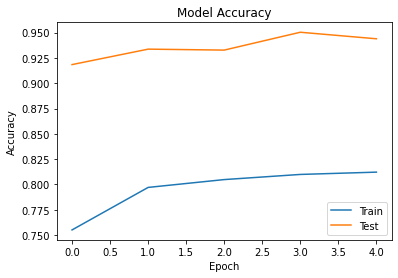

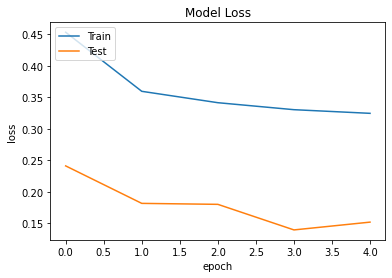

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc = 'upper_left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

# Plotting the confusion matrix

In [37]:
rounded_predictions = np.argmax(predictions, axis =1)

In [38]:
print(rounded_predictions)

[1 1 1 ... 2 1 1]


In [66]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


In [54]:
label_map = train_gen.class_indices
print(label_map)

{'covid': 0, 'non-covid': 1, 'non-informative': 2}


In [53]:
print(model.predict_classes)

<bound method Sequential.predict_classes of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f978c551ac8>>


In [59]:
class_names = ['covid','non-covid', 'non-informative']

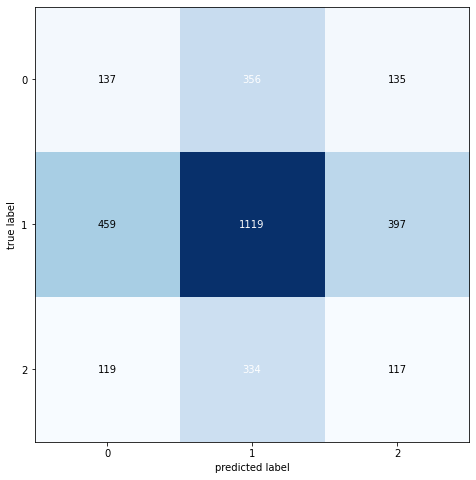

In [73]:
cs = confusion_matrix(labels, rounded_predictions)
cm = plot_confusion_matrix(conf_mat = cs, figsize =(8,8))